In [4]:
import pandas as pd
import numpy as np
from  graphviz import Source
from scipy import misc
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import matplotlib.pyplot as plt
import seaborn as sns

#### Importar dados para analise
Para iniciar a analise dos dados primeiro necessita-se
importar esse dados, os .csv encontrados abaixo são os dados disponibilizados
[aqui](https://archive.ics.uci.edu/ml/datasets/record+linkage+comparison+patterns).
Após carregar cada um dos dados .csv unimos em um unico frame do pandas.

In [5]:
dataframe = pd.DataFrame()
for x in range(1,11):
    dataframe_name = 'data/block_'+str(x)+'.csv'
    new_dataframe = pd.read_csv(dataframe_name)
    dataframe = pd.concat([dataframe,new_dataframe])

frame = dataframe

#### Exibir Frame
Exibir resultado do merge dos frames..

In [6]:
frame.head()

,id_1,id_2,cmp_fname_c1,cmp_fname_c2,cmp_lname_c1,cmp_lname_c2,cmp_sex,cmp_bd,cmp_bm,cmp_by,cmp_plz,is_match
0,37291,53113,0.833333333333333,?,1.0,?,1,1,1,1,0,True
1,39086,47614,1,?,1.0,?,1,1,1,1,1,True
2,70031,70237,1,?,1.0,?,1,1,1,1,1,True
3,84795,97439,1,?,1.0,?,1,1,1,1,1,True
4,36950,42116,1,?,1.0,1,1,1,1,1,1,True


#### Arrumando tipos de dados

In [7]:
broken_columns = list(frame.columns[2:11])

for column in broken_columns:
    frame[column] = frame[column].apply(lambda x: np.NaN if x == '?' else x)
    frame[column] = frame[column].apply(lambda x: float(x) if type(x) == str else x)

In [8]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5749132 entries, 0 to 574912
Data columns (total 12 columns):
id_1            int64
id_2            int64
cmp_fname_c1    float64
cmp_fname_c2    float64
cmp_lname_c1    float64
cmp_lname_c2    float64
cmp_sex         int64
cmp_bd          float64
cmp_bm          float64
cmp_by          float64
cmp_plz         float64
is_match        bool
dtypes: bool(1), float64(8), int64(3)
memory usage: 531.8 MB


#### Verificando a existência de valores nulos

In [9]:
frame.drop(['id_1','id_2','is_match'],axis=1,inplace=True)

In [10]:
melted_frame = pd.melt(frame.notnull())

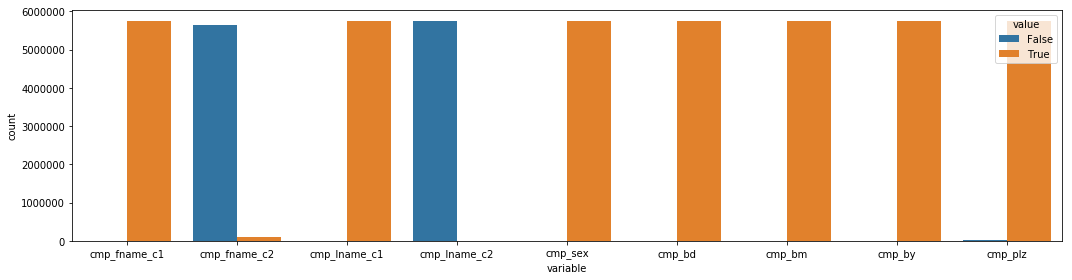

In [11]:
plt.figure(figsize=(15,4))
sns.countplot(melted_frame['variable'],hue=melted_frame['value'])
plt.tight_layout()

No gráfico acima as barras em azul representam o número de valores nulos de cada coluna

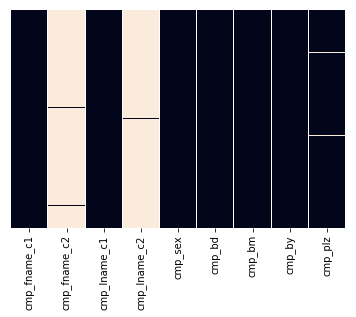

In [12]:
sns.heatmap(frame.isnull(),cbar=False,yticklabels=False)

Acima vemos outro gráfico que representa a quantidade de valores nulos de cada coluna. Nesse caso as partes claras
representam os valores faltantes

#### Removendo colunas vazias
Com a visualização dos graficos é possivel observar que as colunas cmp_fname_c2 e cmp_lname_c2, existem muitos dados faltantes, então ele serão desconsideradas a aplicação dos métodos e nas demais colunas onde existem dados faltantes serão preenchidas pelas medias dos valores dos dados;

Removendo colunas desnecessario para aplicar o modelo.

In [13]:
frame.drop(['cmp_fname_c2','cmp_lname_c2'],axis=1,inplace=True)
frame.head()

,cmp_fname_c1,cmp_lname_c1,cmp_sex,cmp_bd,cmp_bm,cmp_by,cmp_plz
0,0.833333,1.0,1,1.0,1.0,1.0,0.0
1,1.000000,1.0,1,1.0,1.0,1.0,1.0
2,1.000000,1.0,1,1.0,1.0,1.0,1.0
3,1.000000,1.0,1,1.0,1.0,1.0,1.0
4,1.000000,1.0,1,1.0,1.0,1.0,1.0


Aplicando as medias para os demais valores faltantes dos frames.

In [14]:
def preparer_data(frame):
    frame["cmp_fname_c1"] = frame["cmp_fname_c1"].replace(np.NaN,0.000235404896421846)
    frame["cmp_lname_c1"] = frame["cmp_lname_c1"].replace(np.NaN,2.68694413843136e-05)
    frame["cmp_sex"] = frame["cmp_sex"].replace(np.NaN,0.5)
    frame["cmp_bd"] = frame["cmp_bd"].replace(np.NaN,0.032258064516129)
    frame["cmp_bm"] = frame["cmp_bm"].replace(np.NaN,0.0833333333333333)
    frame["cmp_by"] = frame["cmp_by"].replace(np.NaN, 0.00943396226415094)
    frame["cmp_plz"] = frame["cmp_plz"].replace(np.NaN, 0.000422654268808115)
    
    return frame

frame = preparer_data(frame)


#### Verificando a existência de valores nulos

In [15]:
frame.isnull().values.any()

False

Ainda para observar, se as demais features que irão realmente compor o modelo, iremos buscar a correlação entre elas,
casos duas features tenham correlação muito alta, deverão ser desconsideradas no modelo, pois elas basicamente estariam 
trazendo a mesma informação ao modelo.

In [16]:
frame.corr()

,cmp_fname_c1,cmp_lname_c1,cmp_sex,cmp_bd,cmp_bm,cmp_by,cmp_plz
cmp_fname_c1,1.000000,-0.668145,0.151666,0.016742,0.274531,0.033493,0.031607
cmp_lname_c1,-0.668145,1.000000,0.109754,-0.210898,-0.392630,-0.219032,0.101822
cmp_sex,0.151666,0.109754,1.000000,-0.242386,-0.151130,-0.239898,0.008734
cmp_bd,0.016742,-0.210898,-0.242386,1.000000,-0.183648,0.072568,0.085247
cmp_bm,0.274531,-0.392630,-0.151130,-0.183648,1.000000,-0.181056,0.045027
cmp_by,0.033493,-0.219032,-0.239898,0.072568,-0.181056,1.000000,0.086154
cmp_plz,0.031607,0.101822,0.008734,0.085247,0.045027,0.086154,1.000000


Partindo da tabela de correlação podemos intenficar, que os dados estão bem desacoplados, sendo assim podemos utilizalos no nosso modelo.

In [17]:
frame.head()

,cmp_fname_c1,cmp_lname_c1,cmp_sex,cmp_bd,cmp_bm,cmp_by,cmp_plz
0,0.833333,1.0,1,1.0,1.0,1.0,0.0
1,1.000000,1.0,1,1.0,1.0,1.0,1.0
2,1.000000,1.0,1,1.0,1.0,1.0,1.0
3,1.000000,1.0,1,1.0,1.0,1.0,1.0
4,1.000000,1.0,1,1.0,1.0,1.0,1.0


Após esse tramento dos dados, essas features acima serão as que vão incorporar o modelo.